<a href="https://colab.research.google.com/github/Nidaamir083/Hybrid_GenAI_ATC/blob/main/GenAI_Scientific_QA_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 GenAI Scientific QA Pipeline (Hackathon-Ready)

This notebook extracts research abstracts from PubMed, summarizes them, and answers domain-specific questions using an open LLM (`flan-t5-base`).

In [ ]:
# ✅ Install dependencies
!pip install -q biopython transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.4 MB/s eta 0:00:00


In [ ]:
!pip install -q openai arxiv wikipedia sentence-transformers langchain matplotlib langchain-community

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
import requests
import arxiv
import wikipedia
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

In [ ]:
# 🔍 PubMed abstract retriever using Biopython
from Bio import Entrez
import pandas as pd

def fetch_pubmed_articles(query, start_year=2015, end_year=2024, max_results=20):
    Entrez.email = "nida.amir0083@gmail.com"  # Replace with your email
    handle = Entrez.esearch(db="pubmed", term=query,
                            mindate=f"{start_year}/01/01", maxdate=f"{end_year}/12/31",
                            retmax=max_results)
    record = Entrez.read(handle)
    ids = record["IdList"]

    abstracts = []
    sources = []
    handle = Entrez.efetch(db="pubmed", id=ids, rettype="abstract", retmode="text")
    for abstract in handle.read().split("\n\n"):
        clean_abstract = abstract.strip()
        if len(clean_abstract) > 100:
            abstracts.append(clean_abstract)
            sources.append("PubMed")  # Add source

    return pd.DataFrame({"abstract": abstracts, "source": sources})


In [ ]:
# 📥 Fetch abstracts
query = "Drug repurposing for Anaplastic thyroid cancer"
df = fetch_pubmed_articles(query, max_results=20)
df.head(20)

,abstract,source
0,Author information:\n(1)Department of Orthopae...,PubMed
1,Background/Objectives: Anaplastic thyroid canc...,PubMed
2,Conflict of interest statement: Authors Soonch...,PubMed
3,2. Zhejiang Da Xue Xue Bao Yi Xue Ban. 2018 Ma...,PubMed
4,[Identification of key pathways and drug repur...,PubMed
5,Author information:\n(1)Department of Pharmacy...,PubMed
6,OBJECTIVE: To identify hub genes and key pathw...,PubMed
7,目的: 阐明未分化型甲状腺癌（ATC）的分子病理状态，并挖掘其潜在的干预策略。\n方法: \...,PubMed
8,Author information:\n(1)Endocrine Oncology Bra...,PubMed
9,Anaplastic thyroid cancer (ATC) is one of the ...,PubMed


In [ ]:
# 🤖 Load open-access LLM (Flan-T5)
from transformers import pipeline
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def get_wikipedia_background(topic):

    try:
        summary = wikipedia.summary(topic, sentences=5)
        return [{"source": "Wikipedia", "title": topic, "date" : topic, "summary": summary}]
    except Exception:
        return []

In [ ]:
query1 = "drug repurposing for anaplastic thyroid cancer"
df1 = get_wikipedia_background(query1)
df1 = pd.DataFrame(df1)

In [ ]:
def fetch_arxiv_articles(query, max_results=5):
    search = arxiv.Search(query=query, max_results=max_results, sort_by=arxiv.SortCriterion.Relevance)

    articles = []
    for result in search.results():
        published_year = result.published.year
        if published_year >= 2015 and published_year <= 2024:
            articles.append({"source": "arXiv", "title": result.title, "date": result.published, "summary": result.summary})
    return articles

In [ ]:
query2 = "drug repurposing for anaplastic thyroid cancer"
df2 = fetch_arxiv_articles(query, max_results=20)
df2 = pd.DataFrame(df2)
df2.head(20)

<ipython-input-9-180c7f4b2dfc>:5: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


,source,title,date,summary
0,arXiv,ASGARD: A Single-cell Guided pipeline to Aid R...,2021-09-14 00:45:11+00:00,Intercellular heterogeneity is a major obstacl...
1,arXiv,Gene expression and pathway bioinformatics ana...,2019-10-26 12:42:06+00:00,Thyroid cancer is the commonest endocrine mali...
2,arXiv,TCR: A Transformer Based Deep Network for Pred...,2022-07-10 13:01:54+00:00,Predicting clinical outcomes to anti-cancer dr...
3,arXiv,Drug Repurposing for Cancer: An NLP Approach t...,2019-11-18 18:32:25+00:00,More than 200 generic drugs approved by the U....
4,arXiv,Accelerating Complex Disease Treatment through...,2024-06-18 23:40:00+00:00,The objective of this research is to introduce...
5,arXiv,Extracting Thyroid Nodules Characteristics fro...,2023-03-31 20:23:58+00:00,The ultrasound characteristics of thyroid nodu...
6,arXiv,Improving The Diagnosis of Thyroid Cancer by M...,2022-03-27 17:37:18+00:00,Thyroid cancer is a common endocrine carcinoma...
7,arXiv,A systematic review on the role of artificial ...,2020-06-10 14:38:05+00:00,"Thyroid cancer is common worldwide, with a rap..."
8,arXiv,Ensemble Transfer Learning for the Prediction ...,2020-05-13 20:29:48+00:00,Transfer learning has been shown to be effecti...
9,arXiv,NeuroCADR: Drug Repurposing to Reveal Novel An...,2023-09-04 03:21:43+00:00,Drug repurposing is an emerging approach for d...


In [ ]:
def build_merged_report(topic, pubmed_limit=5, arxiv_limit=5):
    pubmed = fetch_pubmed_articles(topic, max_results=pubmed_limit)
    arxiv_articles = fetch_arxiv_articles(topic, max_results=arxiv_limit)
    wiki = get_wikipedia_background(topic)
    return pubmed.to_dict('records') + arxiv_articles + wiki

In [ ]:
# 🧠 Ask a scientific question
def ask_scientific_question(question, context):
    prompt = f"Context: {context}\n\nQuestion: {question}"
    result = qa_pipeline(prompt, max_new_tokens=300)[0]["generated_text"]
    return result.strip()

# 🔍 Sample context and question
# Change is on this line:
context = " ".join(df["abstract"].tolist() + (df1["summary"].tolist() if "summary" in df1 else[]) + df2["summary"].dropna().tolist())[:4000]
question = "What AI tools are used in the diagnosis of Thyroid cancer?"
answer = ask_scientific_question(question, context)
print("🤖 Answer:", answer)

Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 512). Running this sequence through the model will result in indexing errors


🤖 Answer: integrated bioinformatics analysis


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_results(data):
    # Ensure 'source' key exists in all
    for doc in data:
        if 'source' not in doc:
            if 'abstract' in doc:
                doc['source'] = 'PubMed'
            else:
                doc['source'] = 'Unknown'

    df = pd.DataFrame(data)
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x='source', order=df['source'].value_counts().index, palette='pastel')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.title("Source Distribution")
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


query: drug repurposing for anaplastic thyroid cancer


<ipython-input-9-180c7f4b2dfc>:5: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
<ipython-input-13-b9efae6e72d8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='source', order=df['source'].value_counts().index, palette='pastel')


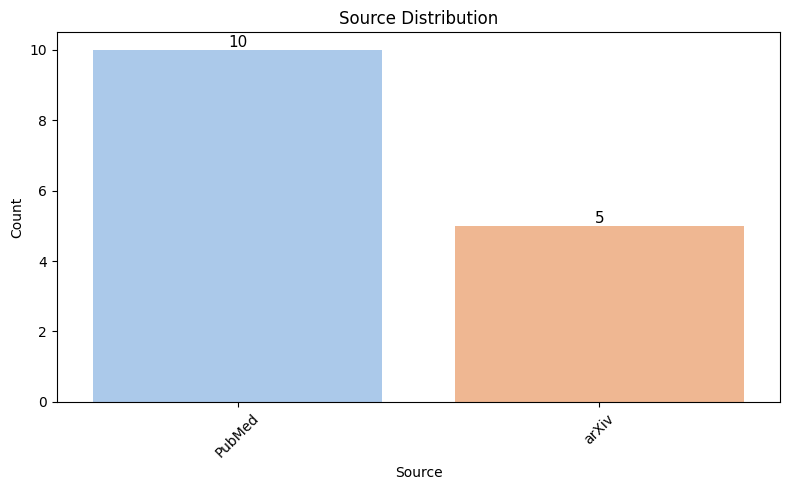



📚 Sources Fetched:
- PubMed: Author information:
(1)Department of Orthopaedic Surgery, CH
- PubMed: Background/Objectives: Anaplastic thyroid cancer (ATC) is an
- PubMed: Conflict of interest statement: Authors Soonchul Lee and Hyu
- PubMed: 2. Zhejiang Da Xue Xue Bao Yi Xue Ban. 2018 May 25;47(2):187
- PubMed: [Identification of key pathways and drug repurposing for ana
- PubMed: Author information:
(1)Department of Pharmacy, Zhejiang Canc
- PubMed: OBJECTIVE: To identify hub genes and key pathways associated
- PubMed: 目的: 阐明未分化型甲状腺癌（ATC）的分子病理状态，并挖掘其潜在的干预策略。
方法: 
利用GEO数据库联合R语言分析
- PubMed: Author information:
(1)Endocrine Oncology BranchNational Can
- PubMed: Anaplastic thyroid cancer (ATC) is one of the most aggressiv
- arXiv: ASGARD: A Single-cell Guided pipeline to Aid Repurposing of 
- arXiv: Gene expression and pathway bioinformatics analysis detect a
- arXiv: TCR: A Transformer Based Deep Network for Predicting Cancer 
- arXiv: Drug Repurposing for Cancer: An NLP Approach to Id

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Insufficient quality findings to generate comprehensive summary.


In [ ]:
if __name__ == "__main__":
    topic = input("query: ")
    merged_data = build_merged_report(topic)
    visualize_results(merged_data)

    print("\n\n📚 Sources Fetched:")
    sources = []
    for doc in merged_data:
        source_info = ""
        if 'source' in doc and 'title' in doc:
            source_info = f"- {doc['source']}: {doc['title'][:60]}"
        elif 'abstract' in doc:
            source_info = f"- PubMed: {doc['abstract'][:60]}"
        elif 'summary' in doc:
            source_info = f"- {doc.get('source', '')}: {doc['summary'][:60]}"

        if source_info:
            print(source_info)
            sources.append(doc)

    print("\n\n🧠 Evidence-Based Summary:")

    if not sources:
        print("No relevant sources found to generate summary.")
    else:
        # Extract key findings with better error handling
        key_findings = []
        for doc in sources:
            try:
                text = doc.get('summary', '') or doc.get('abstract', '') or doc.get('text', '') or ""
                if len(text) > 50:  # Only process if sufficient text exists
                    prompt = (
                        f"Extract one key finding about {topic} from this research, "
                        f"focusing on AI applications. Include specific numbers if available:\n{text[:1500]}"
                    )
                    result = qa_pipeline(prompt, max_new_tokens=120)[0]["generated_text"]
                    if topic.lower() in result.lower():  # Only keep relevant findings
                        key_findings.append(result.strip())
            except Exception as e:
                print(f"Error processing one source: {str(e)[:50]}...")
                continue

        if len(key_findings) >= 3:  # Only generate summary if enough quality findings
            # Generate structured summary
            summary_prompt = (
                "Synthesize these research findings into a cohesive paragraph about AI in thyroid cancer:\n"
                "1. Start with diagnostic applications\n"
                "2. Then discuss treatment/predictive applications\n"
                "3. Conclude with limitations/future directions\n"
                "Include specific performance metrics when available:\n\n"
                + "\n".join(f"- {f}" for f in key_findings)
            )

            try:
                final_summary = qa_pipeline(summary_prompt, max_new_tokens=650)[0]["generated_text"]
                # Post-process to improve quality
                final_summary = final_summary.replace("The text states that", "").replace("According to the article", "")
                print("\n" + final_summary + "\n")
            except Exception as e:
                print(f"Summary generation failed: {str(e)[:50]}...")
                print("\nKey findings instead:\n" + "\n".join(f"- {f}" for f in key_findings))
        else:
            print("Insufficient quality findings to generate comprehensive summary.")
            if key_findings:
                print("\nPartial findings:\n" + "\n".join(f"- {f}" for f in key_findings))